# Lessons learned from racing a Donkey in AVC 2017

All the information I have on the race will be in this notebook including.
* [AVC Race rules](https://avc.sparkfun.com/2016/rules#AVC)
* Schedule: Friday (training & post data), Saturday (test and race?), Sunday (maybe race?)
* Map
* Datasets (see below)
 

In [29]:
%matplotlib inline
import donkeycar as dk
import requests
import pandas as pd
import tarfile
import numpy as np

import os

from PIL import Image

import keras

## Download data

In [2]:
"""
req = requests.get('https://drive.google.com/uc?export=download&id=0Bw0ExbCN1VLxeWJCQUZPM1VZSlE')

zip_path = '/home/wroscoe/data.tar.gz'
with open(zip_path, 'wb') as f:
    f.write(req.content)
    
if (zip_path.endswith("tar.gz")):
    tar = tarfile.open(zip_path, "r:gz")
    tar.extractall('/home/wroscoe/')
    tar.close()
"""

'\nreq = requests.get(\'https://drive.google.com/uc?export=download&id=0Bw0ExbCN1VLxeWJCQUZPM1VZSlE\')\n\nzip_path = \'/home/wroscoe/data.tar.gz\'\nwith open(zip_path, \'wb\') as f:\n    f.write(req.content)\n    \nif (zip_path.endswith("tar.gz")):\n    tar = tarfile.open(zip_path, "r:gz")\n    tar.extractall(\'/home/wroscoe/\')\n    tar.close()\n'

### Read in data

In [35]:
tub_path = '/home/wroscoe/d2/data/tub_30_17-10-15/'
T = dk.parts.Tub(path=tub_path)

df = pd.DataFrame([T.get_json_record(i) for i in T.get_index(shuffled=False)])
#df['user/angle'] = df['user/angle'].shift(-10)
df = df.dropna()

Tub does exist


## Build index

1. read records into dataframe 
2. resolve path names tobe absolute
3. order recrods by timestamp or id. 

In [36]:

df = pd.DataFrame([T.get_json_record(i) for i in T.get_index()])

In [37]:
df.head()

,cam/image_array,user/angle,user/mode,user/throttle
0,703_cam-image_array_.jpg,0.159127,user,0.796105
1,1611_cam-image_array_.jpg,0.000000,user,0.744671
2,689_cam-image_array_.jpg,0.002533,user,0.784940
3,5272_cam-image_array_.jpg,0.000000,user,0.787374
4,5579_cam-image_array_.jpg,-0.287095,user,0.703408


In [38]:
T.types

['image_array', 'float', 'float', 'str']

###  Batch Generator with dataframes

* Load/combine index from many tubs.
* Load record given index id of tub.
* Get type, perform loading action based on type. 
* Apply transform of record (ie, flip, augment)
* Build batch of loaded records. Accepts a pipeline to specify transforms for records.
* Batch generator to return batches of loaded records.
* Split the data into test and validate sets. 

### Record Index Operations.
To allow for more flexibility when manipulating training data. Dataframes are availible before batch generation. 
1. Extra columns (keep percentage, flip Y/N) can be added. 
2. Sequence operations can be performed (ie smoothing. 
3. Create new columns to train on (ie 30 frame look ahead)

#### Smoothing

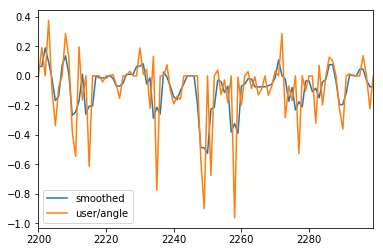

In [34]:
r = df['user/angle'].rolling(3, center=True)
df['smoothed'] = r.mean()
df[['smoothed', 'user/angle']][2200:2300].plot()

## Training 


* Load model.
* Train on batches. 
* Finishing. After training stops automatically, load saved model again and train on full dataset 1 or 2 times. (lower learning rate?) or rely on dropout to prevent overfitting.
* Give an analysis of the trained model. 

## Analysis of model. 

* Output graphs comparing steering and throttle
* Output video showing what the network is queing off of and the predicted steering and throttle values

## Analysis of pilot
* Evaluate a the full pilot's performance against a Tub.
* Show comparison graphs and summary statistics. 
* Evaluate the pilot against some standard datasets. 

## Possition Tags 

Put tags on the back of cars so other cars can gauge the distance between them. 

## Statefull models.

* Put an LSTM below the dense layer of the network to give the network some memory. 
* Update training to train on batches of sequences. 

## Tub Cleaner
* Make simple way to download data. (zip and download link)


## Driving
* Record time of frame. 

## Test parts
* Easy way to test the speed of parts in terms of framerate. 

## Slackbot
Slackbot that shows users locations to get help if they haven't posted to the community before. 

## Old method of loading batches of records

In [84]:
def get_record_from_df(df, data_path, record_transform=None, shuffle=False):
    
    index = list(df.index)
    if shuffle:
        random.shuffle(index)
    while True:
        for i in index:
            row = dict(df.ix[i])
            img = Image.open(os.path.join(data_path, row['cam/image_array']))
            row['cam/image_array'] = np.array(img)
            if record_transform:
                row = record_transform(row)
            yield row

    
def get_batch_from_df(keys, df, record_transform=None, batch_size=128,
                      record_tranform=None, data_path=None, shuffle=False):
    
    record_gen = get_record_from_df(df, data_path, record_transform, shuffle=shuffle)
    
    if keys==None:
        keys = list(df.columns)
    while True:
        record_list = []
        for _ in range(batch_size):
            record_list.append(next(record_gen))

        batch_arrays = {}
        for i, k in enumerate(keys):
            arr = np.array([r[k] for r in record_list])
            #if len(arr.shape) == 1:
            #    arr = arr.reshape(arr.shape + (1,))
            batch_arrays[k] = arr

        yield batch_arrays
        
def train_gen(X_keys, Y_keys, df, batch_size=128, data_path=None, 
              record_transform=None):
    
    batch_gen = get_batch_from_df(X_keys+Y_keys, df, batch_size=128, record_transform=None, 
                                  data_path=data_path)
    while True:
        batch = next(batch_gen)
        X = [batch[k] for k in X_keys]
        Y = [batch[k] for k in Y_keys]
        yield X,Y

In [48]:
img_gen = get_batch_from_df(['cam/image_array'], df, batch_size=len(df), data_path=tub_path)
img = next(img_gen)

In [49]:
predictions = m.predict(img['cam/image_array'])

In [50]:
df['pilot/angle'] = predictions[0]

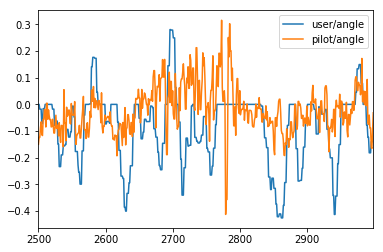

In [56]:
df[['user/angle', 'pilot/angle']][2500:3000].plot()

In [ ]:
predictions = m.predict

## Train
This is the current way models are trained...

In [ ]:
def train(cfg, tub_names, model_name):
    '''
    use the specified data in tub_names to train an artifical neural network
    saves the output trained model as model_name
    '''
    X_keys = ['cam/image_array']
    y_keys = ['user/angle', 'user/throttle']
    
    def rt(record):
        record['user/angle'] = dk.utils.linear_bin(record['user/angle'])
        return record

    kl = dk.parts.KerasCategorical()
    
    tubs = gather_tubs(cfg, tub_names)

    import itertools

    gens = [tub.train_val_gen(X_keys, y_keys, 
                              record_transform=rt, 
                              batch_size=cfg.BATCH_SIZE, 
                              train_split=cfg.TRAIN_TEST_SPLIT) for tub in tubs]


    # Training data generator is the one that keeps cycling through training data generator of all tubs chained together
    # The same for validation generator
    train_gens = itertools.cycle(itertools.chain(*[gen[0] for gen in gens]))
    val_gens = itertools.cycle(itertools.chain(*[gen[1] for gen in gens]))

    model_path = os.path.expanduser(model_name)

    total_records = sum([t.get_num_records() for t in tubs])
    total_train = int(total_records * cfg.TRAIN_TEST_SPLIT)
    total_val = total_records - total_train
    print('train: %d, validation: %d' %(total_train, total_val))
    steps_per_epoch = total_train // cfg.BATCH_SIZE
    print('steps_per_epoch', steps_per_epoch)

    kl.train(train_gens, 
        val_gens, 
        saved_model_path=model_path,
        steps=steps_per_epoch,
        train_split=cfg.TRAIN_TEST_SPLIT)

In [ ]:
def custom_train(cfg, tub_names, model_name):
    '''
    use the specified data in tub_names to train an artifical neural network
    saves the output trained model as model_name
    '''
    import sklearn
    from sklearn.model_selection import train_test_split
    from sklearn.utils import shuffle
    import random
    from PIL import Image
    import numpy as np

    images = []
    angles = []
    throttles = []

    tubs = gather_tubs(cfg, tub_names)

    for tub in tubs:
        num_records = tub.get_num_records()
        for iRec in range(0, num_records):
            record = tub.get_json_record(iRec)

            user_angle = dk.utils.linear_bin(record['user/angle'])
            user_throttle = float(record["user/throttle"])
            image_filename = record["cam/image_array"]
            image_path = os.path.join(tub.path, image_filename)
            
            if (user_angle[7] != 1.0):
                #if the categorical angle is not in the 0 bucket, always include it
                images.append(image_path)
                angles.append(user_angle)
                throttles.append(user_throttle)
            elif (random.randint(0, 9) < 2):
                #Drop a percentage of records where categorical angle is in the 0 bucket
                #increase the number in the conditional above to include more records
                #(< 2 = 20% of 0 angle records included, < 3 = 30% of 0 angle records included, etc.)
                images.append(image_path)
                angles.append(user_angle)
                throttles.append(user_throttle)

    #shuffle and split the data
    train_images, val_images, train_angles, val_angles, train_throttles, val_throttles = train_test_split(images, angles, throttles, shuffle=True, test_size=(1 - cfg.TRAIN_TEST_SPLIT))

    def generator(images, angles, throttles, batch_size=cfg.BATCH_SIZE):
        num_records = len(images)

        while True:
            #shuffle again for good measure
            shuffle(images, angles, throttles)

            for offset in range(0, num_records, batch_size):
                batch_images = images[offset:offset+batch_size]
                batch_angles = angles[offset:offset+batch_size]
                batch_throttles = throttles[offset:offset+batch_size]

                augmented_images = []
                augmented_angles = []
                augmented_throttles = []

                for image_path, angle, throttle in zip(batch_images, batch_angles, batch_throttles):
                    image = Image.open(image_path)
                    image = np.array(image)
                    augmented_images.append(image)
                    augmented_angles.append(angle)
                    augmented_throttles.append(throttle)

                    if (angle[7] != 1.0):
                        #augment the data set with flipped versions of the nonzero angle records
                        augmented_images.append(np.fliplr(image))
                        augmented_angles.append(np.flip(angle, axis=0))
                        augmented_throttles.append(throttle)

                augmented_images = np.array(augmented_images)
                augmented_angles =  np.array(augmented_angles)
                augmented_throttles = np.array(augmented_throttles)

                X = [augmented_images]
                y = [augmented_angles, augmented_throttles]

                yield X, y

    train_gen = generator(train_images, train_angles, train_throttles)
    val_gen = generator(val_images, val_angles, val_throttles)

    kl = dk.parts.KerasCategorical()
    
    tubs = gather_tubs(cfg, tub_names)
    model_path = os.path.expanduser(model_name)

    total_records = len(images)
    total_train = len(train_images)
    total_val = len(val_images)

    print('train: %d, validation: %d' %(total_train, total_val))
    steps_per_epoch = total_train // cfg.BATCH_SIZE
    print('steps_per_epoch', steps_per_epoch)

    kl.train(train_gen, 
        val_gen, 
        saved_model_path=model_path,
        steps=steps_per_epoch,
        train_split=cfg.TRAIN_TEST_SPLIT)